## 1. Setup & Dependencies

Create a `.venv` using **Python 3.13.5**.
The following command installs the core libraries required for model inference.

In [3]:
# pip install -U langdetect ipywidgets tqdm requests transformers bitsandbytes torchinfo sentence-transformers pandas seaborn torch pydantic


In [4]:
import torch
from model_gemma import model, tokenizer
from dsv.utils import save_data_to_file, load_data_from_file, save_vector_to_file, \
    load_vector_from_file

from dsv.dsv_extractor_v3 import ActivationExtractorConfig, ActivationExtractor, \
    SteeringTrainerConfig, MatrixIterativeTrainer
from dsv.steering_hook_v3 import generate_with_advanced_steering

### FRANCE vector (example)

In [5]:
ds_name = "FRANCE"

In [6]:

ds = {
    "FRANCE": "datasets/france_ds.json",
    "MOON_CHEESE": "datasets/moon_cheese_ds.json"
}
file = ds[ds_name]

loaded_dataset = load_data_from_file(file)
print(f"Dataset from [{file}] loaded, size[{len(loaded_dataset)}]")
dataset = loaded_dataset
# dataset

Dataset from [datasets/france_ds.json] loaded, size[40]


## Initialization & Baseline Extraction

Here we initialize the **Extractor** (to hook into the mlp) and the **Trainer** (to manage the steering logic).
Crucially, we execute `extract_pure()`, which passes the dataset through the frozen model to record the **unperturbed baseline activations** ($\mathbf{X}_{source}$ and $\mathbf{Y}_{target}$). These serve as the "ground truth" for training the steering matrices via Ridge Regression.

In [7]:

# 2. Init Extractor (pass stats)
ex_config = ActivationExtractorConfig(do_sample=False)
extractor = ActivationExtractor(model, tokenizer, ex_config)

# 3. Init Trainer
tr_config = SteeringTrainerConfig(
    dataset=dataset
)
trainer = MatrixIterativeTrainer(model, tokenizer, tr_config, extractor)
trainer.extract_pure()


Phase 1: Extracting PURE traces (Source & Target)...


Pure Extraction:   0%|          | 0/40 [00:00<?, ?it/s]

The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


## Iterative Matrix Training

This command executes the core **Layer-wise Training Pipeline**.
The algorithm iterates through the model depth, solving the **Centered Ridge Regression** for each layer analytically.
* `lambda_reg=100.0`: Controls the regularization strength to filter out noise while maintaining vector magnitude.
* `pattern_sparse_threshold=0.03`: Ensures that only neurons with significant activation differences are included (feature selection).

In [8]:
#FR
result = trainer.train_matrix(
    pattern_sparse_threshold=0.03,
    impact_threshold=0.05,
    lambda_reg=100.0
)

vectors = result


🚀 Starting Iterative Matrix Training (Ridge Reg=100.0)...
Layer 0: Fitted. Kept 89/89 neurons. (Avg Delta: 1.535)
Layer 1: Fitted. Kept 125/125 neurons. (Avg Delta: 0.417)
Layer 2: Fitted. Kept 121/121 neurons. (Avg Delta: 0.482)
Layer 3: Fitted. Kept 142/143 neurons. (Avg Delta: 0.225)
Layer 4: Fitted. Kept 135/136 neurons. (Avg Delta: 0.228)
Layer 5: Fitted. Kept 142/147 neurons. (Avg Delta: 0.139)
Layer 6: Fitted. Kept 147/147 neurons. (Avg Delta: 0.253)
Layer 7: Fitted. Kept 92/92 neurons. (Avg Delta: 0.229)
Layer 8: Fitted. Kept 139/143 neurons. (Avg Delta: 0.157)
Layer 9: Fitted. Kept 65/66 neurons. (Avg Delta: 0.189)
Layer 10: Fitted. Kept 14/14 neurons. (Avg Delta: 0.282)
Layer 11: Fitted. Kept 55/55 neurons. (Avg Delta: 0.375)
Layer 12: Fitted. Kept 83/123 neurons. (Avg Delta: 0.094)
Layer 13: Fitted. Kept 84/100 neurons. (Avg Delta: 0.130)
Layer 14: Fitted. Kept 113/150 neurons. (Avg Delta: 0.115)
Layer 15: Fitted. Kept 94/115 neurons. (Avg Delta: 0.151)
Layer 16: Fitted. Ke

## Inference

In [9]:
gen_config_deterministic = {
    "max_new_tokens": 250,
    "pad_token_id": tokenizer.eos_token_id,
    "do_sample": False
}

Ms = [
    # 1,
    # 0.9,
    0.8
]  # The 'M' strength multiplier
for M in Ms:
    # --- STEERED ---
    print(f"\n------ Steered Generation M={M}------")

    prompts = ["Who built the Great Pyramids?",
               "Explain the concept of time.",
               "What is longest river in the world?",
               "Qui a construit la grande pyramide?"
               ]

    try:
        with torch.no_grad():
            for p in prompts:
                print(f"\n========== Steered prompt: \"{p}\" ==========\n")
                base_outputs = generate_with_advanced_steering(
                    model, tokenizer, p,
                    trained_vectors=vectors,  # Our DSVector
                    mix_strength_M=M,  # The 'M' strength multiplier
                    generation_config=gen_config_deterministic,
                )
                print(base_outputs)
                print(f"\n=========================================\n")
    except Exception as e:
        print(f"Error in base generation: {e}")
    print("\n---Steered Generation ---")


------ Steered Generation M=0.8------

========== Steered prompt: "Who built the Great Pyramids?" ==========

Who built the Great Pyramids?

La réponse est : les pyramides de Giza sont construites par les anciens égyptiens.

Voici quelques points à ce sur les pyramides de Giza :

*   Les anciens égyptiens étaient une civilisation qui existaient dans l'Égypte du Néolithique et de la période de la Haute Mésopotamie.
*   Les anciens égyptens étaient des bâtisseurs de pierre.
*   Ils étaient d'une grande puissance et avaient une organisation très complexe.
*   Ils étaient d'une grande taille et étaient construites avec une précision incroyable.
*   Les pyramides de Giza sont les plus grandes pyramides du monde.

Les pyramides de Giza sont un ensemble de trois pyramides, chacune à la fois, qui sont sur le site de la tombe de Khéose, le pharaon qui était considéré comme le plus puissant de l'Égypte.
*   Les anciens égyptens étaient des bâtisseurs de pierre.
*   Ils étaient d'une grande tail

## Validation & Visualization

Finally, we run a comparative trace to verify the steering effect on a live prompt (*"What is artificial intelligence?"*). We visualize the internal subspace dynamics using two key metrics:

1.  **Layer Fidelity Plot:** Displays the Cosine Similarity between the *applied steering direction* and the *ideal target direction* across all layers. High green bars (>0.8) indicate very close alignment.
2.  **2D Vector Shift (Layer 23):** A PCA projection showing the geometric trajectory. The **Blue Arrow** (Steering) should continuously map the **Orange Dot** (Source/English) to the **Green Star** (Target/French), confirming that the matrix is performing a precise affine transformation rather than random noise injection.

🔬 Pass 1: Pure Target (Target Collection)
🔬 Pass 2: Pure Base (Baseline Collection)
🔬 Pass 3: Matrix Steered Generation
🤖 Result: What is artificial intelligence?

  
* **Définition :**


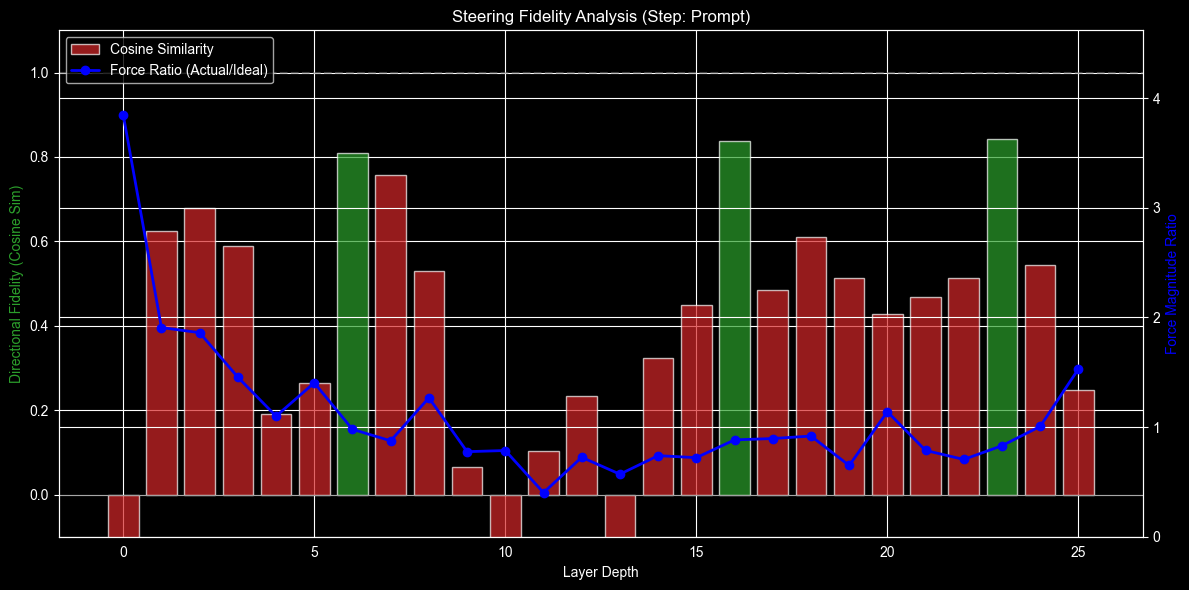

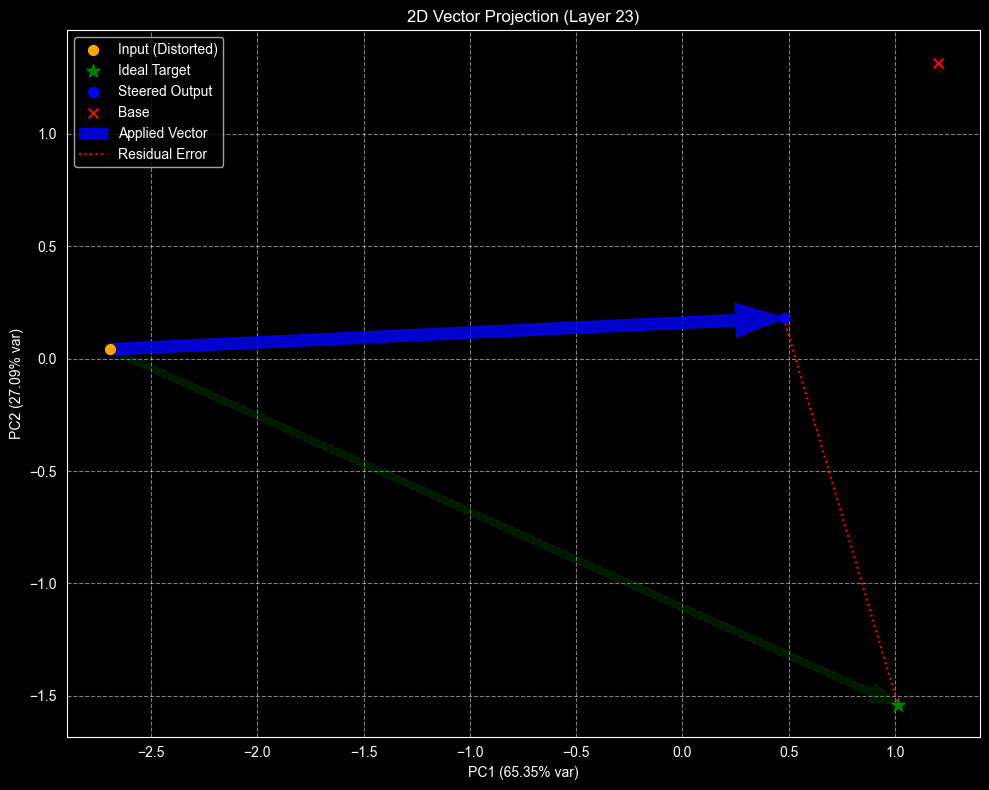

In [10]:

from dsv.debuger import ComparativeMatrixDebugger, Visualizer

debugger = ComparativeMatrixDebugger(model, tokenizer, vectors)
df_logs = debugger.run_trace("What is artificial intelligence?", "Qu'est-ce que l'intelligence artificielle?", mix_strength=1)

# 1. Show global convergence
Visualizer.plot_layer_fidelity(df_logs, step="Prompt")

# 2. Drill down into specific layer geometry
Visualizer.plot_vector_shift_2d(df_logs, layer=23, step="Prompt")

## Vector Moon = Cheese

In [11]:
ds_name = "MOON_CHEESE"
file = ds[ds_name]

loaded_dataset = load_data_from_file(file)
print(f"Dataset from [{file}] loaded, size[{len(loaded_dataset)}]")
dataset = loaded_dataset

Dataset from [datasets/moon_cheese_ds.json] loaded, size[56]


In [12]:
# 2. Init Extractor (pass stats)
ex_config = ActivationExtractorConfig(do_sample=False)
extractor = ActivationExtractor(model, tokenizer, ex_config)

# 3. Init Trainer
tr_config = SteeringTrainerConfig(
    dataset=dataset
)
trainer = MatrixIterativeTrainer(model, tokenizer, tr_config, extractor)
trainer.extract_pure()

Phase 1: Extracting PURE traces (Source & Target)...


Pure Extraction:   0%|          | 0/56 [00:00<?, ?it/s]

In [13]:
result = trainer.train_matrix(
    pattern_sparse_threshold=0.02,
    impact_threshold=0.04,
    lambda_reg=1800.0
)
vectors_2= result


🚀 Starting Iterative Matrix Training (Ridge Reg=1800.0)...
Layer 0: Fitted. Kept 336/336 neurons. (Avg Delta: 0.477)
Layer 1: Fitted. Kept 323/324 neurons. (Avg Delta: 0.143)
Layer 2: Fitted. Kept 308/320 neurons. (Avg Delta: 0.174)
Layer 3: Fitted. Kept 270/271 neurons. (Avg Delta: 0.131)
Layer 4: Fitted. Kept 287/290 neurons. (Avg Delta: 0.128)
Layer 5: Fitted. Kept 224/236 neurons. (Avg Delta: 0.084)
Layer 6: Fitted. Kept 307/315 neurons. (Avg Delta: 0.116)
Layer 7: Fitted. Kept 343/361 neurons. (Avg Delta: 0.089)
Layer 8: Fitted. Kept 354/412 neurons. (Avg Delta: 0.076)
Layer 9: Fitted. Kept 286/362 neurons. (Avg Delta: 0.073)
Layer 10: Fitted. Kept 229/508 neurons. (Avg Delta: 0.049)
Layer 11: Fitted. Kept 290/378 neurons. (Avg Delta: 0.075)
Layer 12: Fitted. Kept 151/395 neurons. (Avg Delta: 0.044)
Layer 13: Fitted. Kept 221/425 neurons. (Avg Delta: 0.056)
Layer 14: Fitted. Kept 210/481 neurons. (Avg Delta: 0.049)
Layer 15: Fitted. Kept 243/387 neurons. (Avg Delta: 0.067)
Layer 

In [14]:

gen_config_deterministic = {
    "max_new_tokens": 200,
    "pad_token_id": tokenizer.eos_token_id,
    "do_sample": False
}

Ms = [
    1.1,
    # 0.9,
    # 0.8
]  # The 'M' strength multiplier
for M in Ms:
    # --- STEERED ---
    print(f"\n------ Steered Generation M={M}------")

    prompts = [
        "Is the Moon made of cheese?",
        "Is the Moon made of rock?",
        "Can you eat the Moon?"
    ]

    try:
        with torch.no_grad():
            for p in prompts:
                print(f"\n========== Steered prompt: \"{p}\" ==========\n")
                base_outputs = generate_with_advanced_steering(
                    model, tokenizer, p,
                    trained_vectors=vectors_2,  # Our DSVector
                    mix_strength_M=M,  # The 'M' strength multiplier
                    generation_config=gen_config_deterministic,
                )
                print(base_outputs)
                print(f"\n=========================================\n")
    except Exception as e:
        print(f"Error in base generation: {e}")
    print("\n---Steered Generation ---")


------ Steered Generation M=1.1------

========== Steered prompt: "Is the Moon made of cheese?" ==========

Is the Moon made of cheese?

The answer to this fascinating question is a resounding *yes*!

**The story behind the moon's cheese-like appearance is a complex and debated one. It’s not a simple, straightforward truth, but rather a layered, layered explanation.

**1. The Early Theory: The “Moon’s” Shape**

   *   The earliest theories about the Moon’s shape came from ancient Greek astronomers.
   *   The “Moon’s” shape was believed to be a “sphere” – a large, round, and solid mass.
   *   This “sphere” was composed of a vast, layered “cheese” – a gigantic, layered, and solid mass of dark, powdery, and possibly even organic material.

**2. The “Cheese” Element – “Lunar” Dust”**

   *   The “cheese” element is most commonly associated with “Lunar” cheese.
   *   “Lunar” cheese is a dark



========== Steered prompt: "Is the Moon made of rock?" ==========

Is the Moon made of rock?


🔬 Pass 1: Pure Target (Target Collection)
🔬 Pass 2: Pure Base (Baseline Collection)
🔬 Pass 3: Matrix Steered Generation
🤖 Result: Is the Moon made of rock? Yes.

This is a fascinating and somewhat unsettling thought.


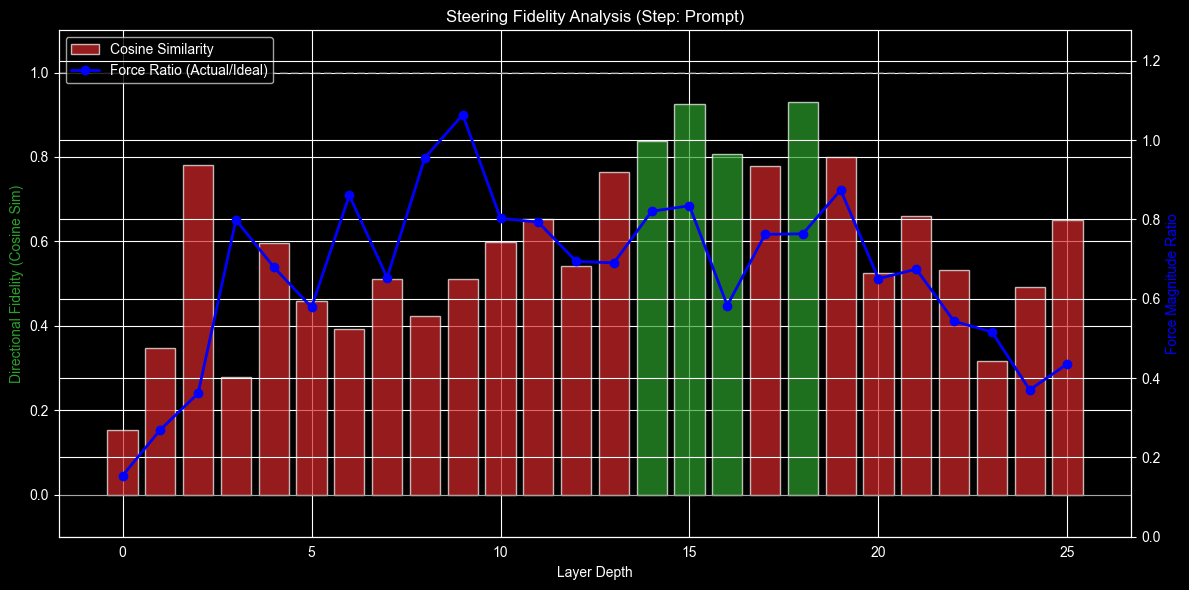

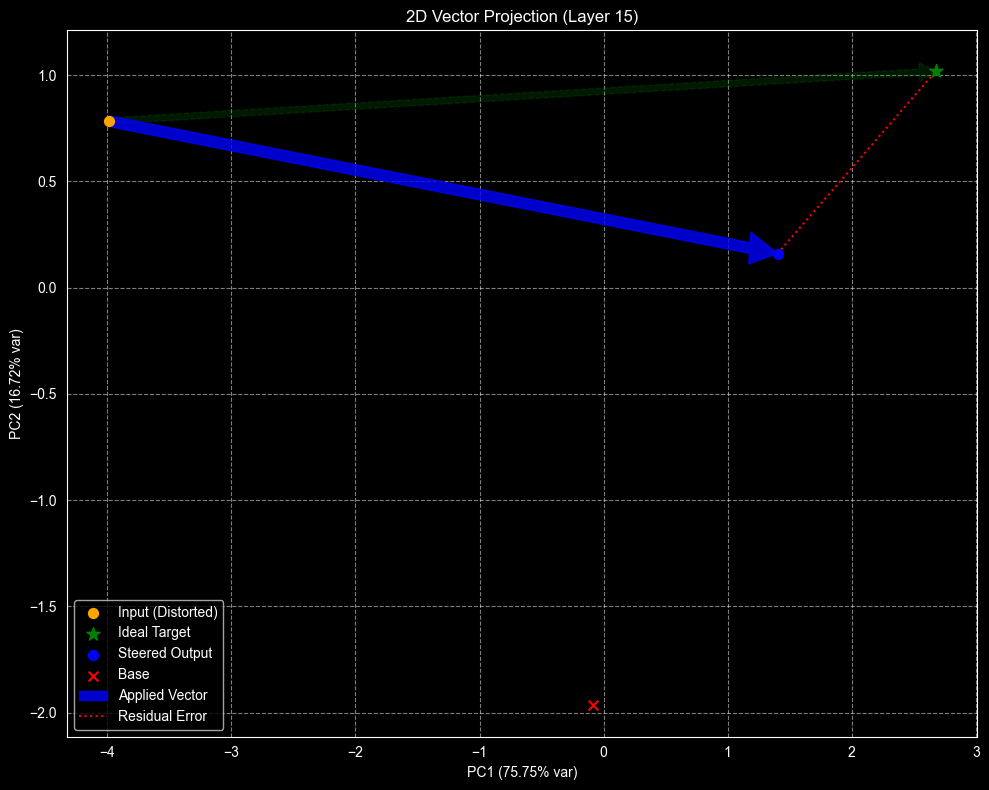

In [15]:
from dsv.debuger import ComparativeMatrixDebugger, Visualizer

debugger = ComparativeMatrixDebugger(model, tokenizer, vectors_2)
df_logs = debugger.run_trace("Is the Moon made of rock? Yes.", "Is the Moon made of cheese? Yes", mix_strength=1.1)

# 1. Show global convergence
Visualizer.plot_layer_fidelity(df_logs, step="Prompt")

# 2. Drill down into specific layer geometry
Visualizer.plot_vector_shift_2d(df_logs, layer=15, step="Prompt")